#Simple EDA for IndoSum dataset

##Import everything needed

In [3]:
import pandas as pd
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import random
import torch

from tqdm import tqdm

In [4]:
# global config

sns.set_style('ticks')

In [5]:
# install another depedencies

!pip install evaluate rouge_score
import evaluate

##Finding files

In [6]:
! chmod 600 /content/kaggle.json

In [7]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d linkgish/indosum

indosum.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip /content/indosum.zip

Archive:  /content/indosum.zip
  inflating: indosum/CHANGELOG.txt   
  inflating: indosum/README.txt      
  inflating: indosum/dev.01.jsonl    
  inflating: indosum/dev.02.jsonl    
  inflating: indosum/dev.03.jsonl    
  inflating: indosum/dev.04.jsonl    
  inflating: indosum/dev.05.jsonl    
  inflating: indosum/test.01.jsonl   
  inflating: indosum/test.02.jsonl   
  inflating: indosum/test.03.jsonl   
  inflating: indosum/test.04.jsonl   
  inflating: indosum/test.05.jsonl   
  inflating: indosum/train.01.jsonl  
  inflating: indosum/train.02.jsonl  
  inflating: indosum/train.03.jsonl  
  inflating: indosum/train.04.jsonl  
  inflating: indosum/train.05.jsonl  


In [8]:
# Detect train, dev, and test files
DATASET_ROOT = '/content/indosum'

files_id_dir = os.listdir(DATASET_ROOT)
train_files = []
dev_files = []
test_files = []

for filename in files_id_dir:
    if 'train' in filename:
        train_files.append(filename)
    elif 'dev' in filename:
        dev_files.append(filename)
    elif 'test' in filename:
        test_files.append(filename)

train_files, dev_files, test_files

(['train.01.jsonl',
  'train.04.jsonl',
  'train.05.jsonl',
  'train.02.jsonl',
  'train.03.jsonl'],
 ['dev.03.jsonl',
  'dev.04.jsonl',
  'dev.05.jsonl',
  'dev.02.jsonl',
  'dev.01.jsonl'],
 ['test.04.jsonl',
  'test.01.jsonl',
  'test.03.jsonl',
  'test.05.jsonl',
  'test.02.jsonl'])

##Pre-procesing Data

In [9]:
def load_file_to_json_list(filename):
    file = os.path.join(DATASET_ROOT, filename)
    data = []
    with open(file, 'r') as f:
        json_list = list(f)
        for json_str in tqdm(json_list, desc=f'Loading data {filename}'):
            d = json.loads(json_str)
            data.append(d)
    return data

In [10]:
# only for testing purpose
json_list = load_file_to_json_list(dev_files[0])
len(json_list), json_list[0].keys()

Loading data dev.03.jsonl: 100%|██████████| 747/747 [00:00<00:00, 12571.60it/s]


(747,
 dict_keys(['category', 'gold_labels', 'id', 'paragraphs', 'source', 'source_url', 'summary']))

Converter from raw data to more readable data

In [11]:
def label_to_dict_str(label_list):
    label_dict = {} # key = paragraph_id : value = label list
    for i, label in enumerate(label_list[:]):
        label_dict[i] = label

    json_str = json.dumps(label_dict)
    num = len(label_dict)
    return json_str, num

In [12]:
# only for testing purpose
label_to_dict_str(json_list[0]['gold_labels'])

('{"0": [true, true], "1": [false, false], "2": [true], "3": [false], "4": [false], "5": [false], "6": [false, false], "7": [false, false], "8": [false, false, false], "9": [false, false], "10": [false, false, false], "11": [false, false, false]}',
 12)

In [13]:
def paragraph_to_dict_str(paragraph_list):
    paragraph_dict = {} # key = paragraph_id : value = paragraph list
    for i, paragraph in enumerate(paragraph_list):
        new_paragraph = []
        for sentence in paragraph:
            sentence = ' '.join(sentence)
            new_paragraph.append(sentence)
        paragraph_dict[i] = new_paragraph

    json_str = json.dumps(paragraph_dict)
    num = len(paragraph_dict)
    return json_str, num

In [14]:
# only for testing purpose
paragraph_list = json_list[0]['paragraphs']
paragraph_to_dict_str(paragraph_list)

('{"0": ["Jakarta , CNN Indonesia - - Edward Snowden mengkritik kehadiran Google Allo sebagai ancaman baru terhadap privasi pengguna internet .", "Pembocor ribuan dokumen rahasia Amerika Serikat itu melabeli Allo sebagai aplikasi yang \' berbahaya \' dan harus dihindari ."], "1": ["\\" Apa itu #Allo ?", "Sebuah aplikasi Google yang bisa merekam setiap pesan yang kalian kirim dan bisa diminta kepolisian , \\" cuit Snowden di akun Twitter miliknya , kemarin ( 21 / 9 ) ."], "2": ["Google menciptakan Allo untuk bersaing dengan aplikasi pesan instan WhatsApp dengan mengusung sejumlah fitur andalan seperti chatbot Google Assistant dan Smart Reply ."], "3": ["Ia memprediksi Allo berencana mengumpulkan lebih banyak data penggunanya dengan fitur-fitur baru tersebut yang tercermin dari pernyataan Google ."], "4": ["\\" Makin sering kita menggunakannya , kemampuan bot makin berkembang , \\" ungkap Amit Fulay , manajer produk Google dalam brog resmi perusahaan ."], "5": ["Snowden mengartikan perny

In [15]:
def paragraph_to_text(raw_paragraph_list):
    new_paragraph_list = []
    for i, paragraph in enumerate(raw_paragraph_list):
        paragraph_list = []
        for sentence in paragraph:
            sentence = ' '.join(sentence)
            paragraph_list.append(sentence)

        new_paragraph = ' '.join(paragraph_list)
        new_paragraph_list.append(new_paragraph)

    paragraph_str = ' '.join(new_paragraph_list)
    return paragraph_str

In [16]:
pl = json_list[0]['paragraphs']
paragraph_to_text(pl)

'Jakarta , CNN Indonesia - - Edward Snowden mengkritik kehadiran Google Allo sebagai ancaman baru terhadap privasi pengguna internet . Pembocor ribuan dokumen rahasia Amerika Serikat itu melabeli Allo sebagai aplikasi yang \' berbahaya \' dan harus dihindari . " Apa itu #Allo ? Sebuah aplikasi Google yang bisa merekam setiap pesan yang kalian kirim dan bisa diminta kepolisian , " cuit Snowden di akun Twitter miliknya , kemarin ( 21 / 9 ) . Google menciptakan Allo untuk bersaing dengan aplikasi pesan instan WhatsApp dengan mengusung sejumlah fitur andalan seperti chatbot Google Assistant dan Smart Reply . Ia memprediksi Allo berencana mengumpulkan lebih banyak data penggunanya dengan fitur-fitur baru tersebut yang tercermin dari pernyataan Google . " Makin sering kita menggunakannya , kemampuan bot makin berkembang , " ungkap Amit Fulay , manajer produk Google dalam brog resmi perusahaan . Snowden mengartikan pernyataan Google tersebut sebagai pemberitahuan bahwa mereka akan menyimpan s

In [17]:
def summary_to_dict_str(summary_list):
    summary_dict = {} # key = summary_id : value = summary sentence
    for i, summary in enumerate(summary_list):
        summary_dict[i] = ' '.join(summary)

    json_str = json.dumps(summary_dict)
    num = len(summary_dict)
    return json_str, num

In [18]:
# only for testing purpose
summary_to_dict_str(json_list[0]['summary'])

('{"0": "Edward Snowden , pembocor ribuan dokumen rahasia Amerika Serikat , mengkritik kehadiran Google Allo sebagai ancaman baru terhadap privasi pengguna internet .", "1": "Menurutnya , Allo adalah aplikasi yang \' berbahaya \' dan harus dihindari .", "2": "Google menciptakan Allo untuk bersaing dengan aplikasi pesan instan WhatsApp dengan mengusung sejumlah fitur andalan seperti chatbot Google Assistant dan Smart Reply .", "3": "Allo berencana mengumpulkan banyak data penggunanya ."}',
 4)

In [19]:
def summary_to_text(raw_summary_list):
    summary_list = []
    for i, summary in enumerate(raw_summary_list):
        summary_list.append(' '.join(summary))

    summary_str = ' '.join(summary_list)
    return summary_str

In [20]:
# only for testing purpose
summary_to_text(json_list[0]['summary'])

"Edward Snowden , pembocor ribuan dokumen rahasia Amerika Serikat , mengkritik kehadiran Google Allo sebagai ancaman baru terhadap privasi pengguna internet . Menurutnya , Allo adalah aplikasi yang ' berbahaya ' dan harus dihindari . Google menciptakan Allo untuk bersaing dengan aplikasi pesan instan WhatsApp dengan mengusung sejumlah fitur andalan seperti chatbot Google Assistant dan Smart Reply . Allo berencana mengumpulkan banyak data penggunanya ."

Altering raw data to a new format

In [21]:
def alter_json_data(json_list_data, filename=''):
    new_json_list = []
    for json_data in tqdm(json_list_data, desc=f'Altering json data {filename}'):
        json_data = json_data.copy()
        json_data['gold_labels'], _ = label_to_dict_str(json_data['gold_labels'])
        json_data['news_text'] = paragraph_to_text(json_data['paragraphs'])
        json_data['paragraphs'], num_paragraph = paragraph_to_dict_str(json_data['paragraphs'])
        json_data['num_of_paragraphs'] = num_paragraph
        json_data['summary_text'] = summary_to_text(json_data['summary'])
        json_data['summary'], num_summary = summary_to_dict_str(json_data['summary'])
        json_data['num_of_summary'] = num_summary

        new_json_list.append(json_data)

    return new_json_list

In [22]:
# only for testing purpose
json_list_alter = alter_json_data(json_list)
len(json_list_alter)

Altering json data : 100%|██████████| 747/747 [00:00<00:00, 4961.71it/s]


747

Create pandas DataFrame

In [23]:
def create_dataset(jsonl):
    header = list(jsonl[0].keys())
    dataset_list = []
    for json_data in jsonl:
        row = []
        for h in header:
            row.append(json_data[h])
        dataset_list.append(row)

    return header, dataset_list

In [24]:
def create_dataset_from_files(file_list):
    df_header = None
    dataset_list = []
    for filename in file_list:
        json_l = load_file_to_json_list(filename)
        new_json_l = alter_json_data(json_l, filename)
        header, dataset_part = create_dataset(new_json_l)

        if not df_header: df_header = header
        dataset_list.extend(dataset_part)

    df_full = pd.DataFrame().from_records(dataset_list)
    df_full = df_full.rename(columns=dict(enumerate(header)))
    return df_full

In [25]:
df_train = create_dataset_from_files(train_files)
df_dev = create_dataset_from_files(dev_files)
df_test = create_dataset_from_files(test_files)

Altering json data test.02.jsonl: 100%|██████████| 3762/3762 [00:00<00:00, 11181.69it/s]


In [26]:
df_train.head()

,category,gold_labels,id,paragraphs,source,source_url,summary,news_text,num_of_paragraphs,summary_text,num_of_summary
0,tajuk utama,"{""0"": [false, true], ""1"": [true, true], ""2"": [...",1501893029-lula-kamal-dokter-ryan-thamrin-saki...,"{""0"": [""Jakarta , CNN Indonesia - - Dokter Rya...",cnn indonesia,https://www.cnnindonesia.com/hiburan/201708041...,"{""0"": ""Dokter Lula Kamal yang merupakan selebr...","Jakarta , CNN Indonesia - - Dokter Ryan Thamri...",9,Dokter Lula Kamal yang merupakan selebriti sek...,3
1,teknologi,"{""0"": [false, false, false, false], ""1"": [fals...",1509072914-dua-smartphone-zenfone-baru-tawarka...,"{""0"": [""Selfie ialah salah satu tema terpanas ...",dailysocial.id,https://dailysocial.id/post/dua-smartphone-zen...,"{""0"": ""Asus memperkenalkan \u00a0 ZenFone gene...",Selfie ialah salah satu tema terpanas di kalan...,14,Asus memperkenalkan ZenFone generasi keempat...,3
2,hiburan,"{""0"": [true], ""1"": [true], ""2"": [false, false]...",1510613677-songsong-visit-2020-bengkulu-perkua...,"{""0"": [""Jakarta , CNN Indonesia - - Dinas Pari...",cnn indonesia,https://www.cnnindonesia.com/gaya-hidup/201711...,"{""0"": ""Dinas Pariwisata Provinsi Bengkulu kemb...","Jakarta , CNN Indonesia - - Dinas Pariwisata P...",21,Dinas Pariwisata Provinsi Bengkulu kembali men...,2
3,tajuk utama,"{""0"": [true, true], ""1"": [false, false, false]...",1502706803-icw-ada-kejanggalan-atas-tewasnya-s...,"{""0"": [""Merdeka.com - Indonesia Corruption Wat...",merdeka,https://www.merdeka.com/peristiwa/icw-merasa-a...,"{""0"": ""Indonesia Corruption Watch ( ICW ) memi...",Merdeka.com - Indonesia Corruption Watch ( ICW...,5,Indonesia Corruption Watch ( ICW ) meminta Kom...,2
4,tajuk utama,"{""0"": [false, true], ""1"": [true, true, true], ...",1503039338-pembagian-sepeda-usai-upacara-penur...,"{""0"": [""Merdeka.com - Presiden Joko Widodo ( J...",merdeka,https://www.merdeka.com/peristiwa/usai-upacara...,"{""0"": ""Jokowi memimpin upacara penurunan bende...",Merdeka.com - Presiden Joko Widodo ( Jokowi ) ...,7,Jokowi memimpin upacara penurunan bendera . Us...,5


##EDA

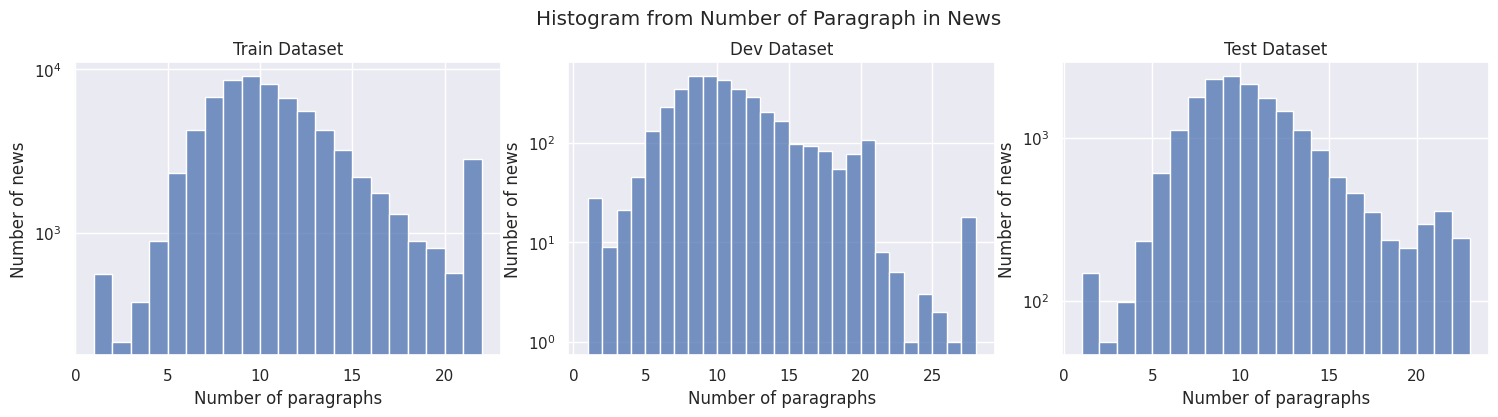

In [27]:
sns.set(rc={'figure.figsize':(15, 4)})
f, axes = plt.subplots(1, 3)
f.suptitle("Histogram from Number of Paragraph in News")
f.tight_layout()
hist0 = sns.histplot(data=df_train['num_of_paragraphs'], binwidth=1, ax=axes[0]).set(
    title='Train Dataset',
    xlabel='Number of paragraphs',
    ylabel='Number of news',
    yscale='log'
)
hist1 = sns.histplot(data=df_dev['num_of_paragraphs'], binwidth=1, ax=axes[1]).set(
    title='Dev Dataset',
    xlabel='Number of paragraphs',
    ylabel='Number of news',
    yscale='log'
)
hist2 = sns.histplot(data=df_test['num_of_paragraphs'], binwidth=1, ax=axes[2]).set(
    title='Test Dataset',
    xlabel='Number of paragraphs',
    ylabel='Number of news',
    yscale='log'
)

##Histogram of Summary Lengths

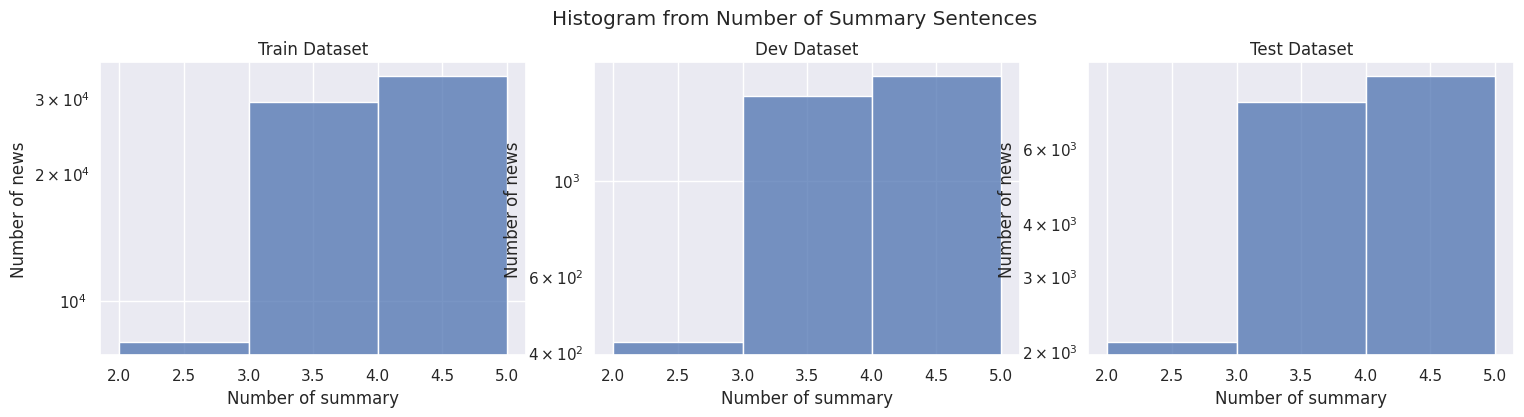

In [28]:
sns.set(rc={'figure.figsize':(15, 4)})
f, axes = plt.subplots(1, 3)
f.suptitle("Histogram from Number of Summary Sentences")
f.tight_layout()
hist0 = sns.histplot(data=df_train['num_of_summary'], binwidth=1, ax=axes[0]).set(
    title='Train Dataset',
    xlabel='Number of summary',
    ylabel='Number of news',
    yscale='log'
)
hist1 = sns.histplot(data=df_dev['num_of_summary'], binwidth=1, ax=axes[1]).set(
    title='Dev Dataset',
    xlabel='Number of summary',
    ylabel='Number of news',
    yscale='log'
)
hist2 = sns.histplot(data=df_test['num_of_summary'], binwidth=1, ax=axes[2]).set(
    title='Test Dataset',
    xlabel='Number of summary',
    ylabel='Number of news',
    yscale='log'
)

##Histogram from Number Characters in News

In [29]:
df_train['paragraphs_text_len'] = df_train['news_text'].str.len()
df_dev['paragraphs_text_len'] = df_dev['news_text'].str.len()
df_test['paragraphs_text_len'] = df_test['news_text'].str.len()

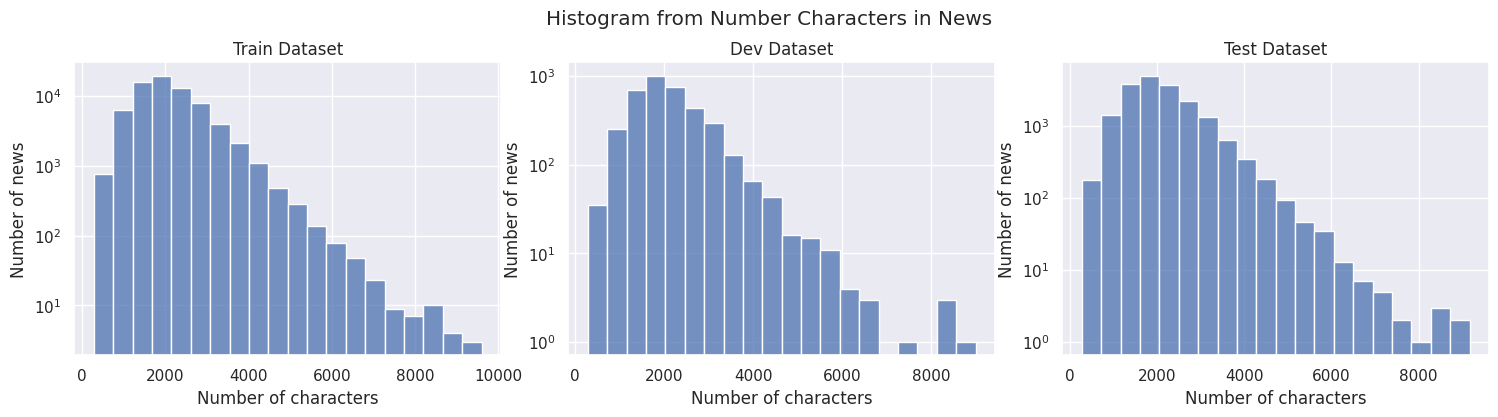

In [30]:
sns.set(rc={'figure.figsize':(15, 4)})
f, axes = plt.subplots(1, 3)
f.suptitle("Histogram from Number Characters in News")
f.tight_layout()
hist0 = sns.histplot(data=df_train['paragraphs_text_len'], bins=20, ax=axes[0]).set(
    title='Train Dataset',
    xlabel='Number of characters',
    ylabel='Number of news',
    yscale='log'
)
hist1 = sns.histplot(data=df_dev['paragraphs_text_len'], bins=20, ax=axes[1]).set(
    title='Dev Dataset',
    xlabel='Number of characters',
    ylabel='Number of news',
    yscale='log'
)
hist2 = sns.histplot(data=df_test['paragraphs_text_len'], bins=20, ax=axes[2]).set(
    title='Test Dataset',
    xlabel='Number of characters',
    ylabel='Number of news',
    yscale='log'
)

##Histogram from Number Characters in Summary

In [31]:
df_train['summary_text_len'] = df_train['summary_text'].str.len()
df_dev['summary_text_len'] = df_dev['summary_text'].str.len()
df_test['summary_text_len'] = df_test['summary_text'].str.len()

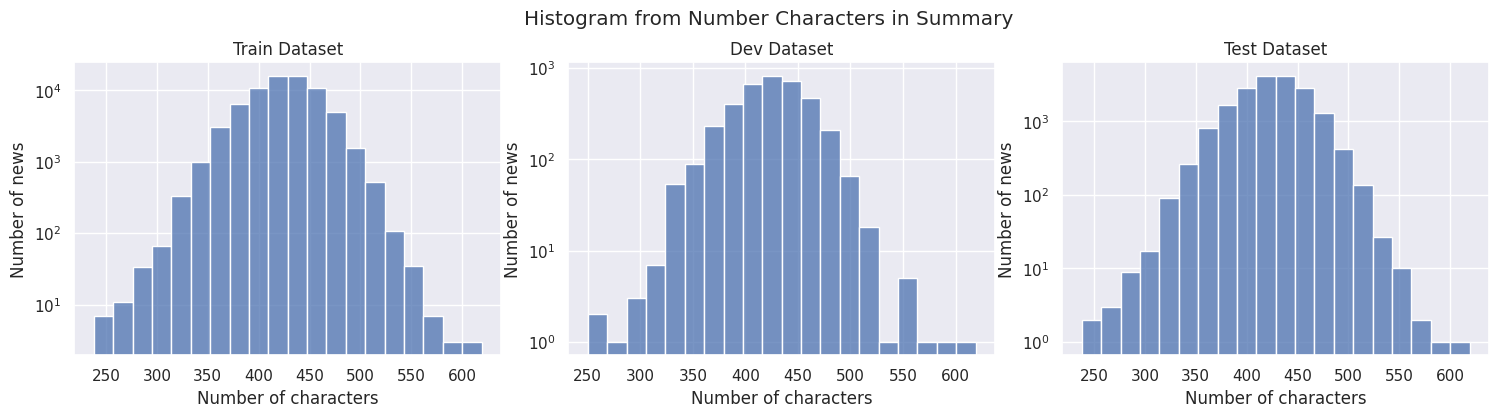

In [32]:
sns.set(rc={'figure.figsize':(15, 4)})
f, axes = plt.subplots(1, 3)
f.suptitle("Histogram from Number Characters in Summary")
f.tight_layout()
hist0 = sns.histplot(data=df_train['summary_text_len'], bins=20, ax=axes[0]).set(
    title='Train Dataset',
    xlabel='Number of characters',
    ylabel='Number of news',
    yscale='log'
)
hist1 = sns.histplot(data=df_dev['summary_text_len'], bins=20, ax=axes[1]).set(
    title='Dev Dataset',
    xlabel='Number of characters',
    ylabel='Number of news',
    yscale='log'
)
hist2 = sns.histplot(data=df_test['summary_text_len'], bins=20, ax=axes[2]).set(
    title='Test Dataset',
    xlabel='Number of characters',
    ylabel='Number of news',
    yscale='log'
)

#Machine Learning Text Summarization

In [1]:
!pip install transformers
!pip install sentencepiece

In [2]:
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration

t5_tokenizer = T5Tokenizer.from_pretrained("panggi/t5-base-indonesian-summarization-cased")
t5_model = T5ForConditionalGeneration.from_pretrained("panggi/t5-base-indonesian-summarization-cased")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [33]:
import torch

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device ", device)
t5_model = t5_model.to(device)

device  cpu


In [35]:
def generate_summary(article, max_length, tokenizer, model):
    input_ids = tokenizer.encode(article, return_tensors='pt')
    input_ids = input_ids.to(device)
    summary_ids = model.generate(input_ids,
                max_length=max_length,
                num_beams=2,
                repetition_penalty=2.5,
                length_penalty=1.0,
                early_stopping=True,
                no_repeat_ngram_size=2,
                use_cache=True)
    summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary_text

In [36]:
# summary max length
max_length = df_test['summary_text'].str.len().max()
max_length

619

In [38]:
summary_generated = []
# counter = 0
# for i, row in tqdm(df_test[['id', 'news_text']].iterrows(), total=df_test.shape[0]):
for i, row in tqdm(df_test[['id', 'news_text']].head(10).iterrows(), total=10):
    sg = generate_summary(row['news_text'], max_length, t5_tokenizer, t5_model)
    summary_generated.append([row['id'], sg])

#     # limiter, for checking only
#     counter += 1
#     if counter == 10:
#         break

100%|██████████| 10/10 [02:16<00:00, 13.65s/it]


In [39]:
df_summary_generated = pd.DataFrame(summary_generated)
df_summary_generated = df_summary_generated.rename(columns={0:'id', 1: 'summary_generated'})
used_id = df_summary_generated['id'].values
df_summary_generated.head()

,id,summary_generated
0,1504151262-wiranto-yakin-uang-bos-first-travel...,"Menteri Koordinator bidang Politik, Hukum, dan..."
1,1514888989-malaysian-masters-2018-bakal-diikut...,Turnamen Malaysia Masters 2018 yang akan berla...
2,1495703700-potensi-kotoran-sapi-rp-643-triliun...,Fakultas Peternakan UGM memprediksi potensi ek...
3,1501628400-aktor-intelektual-kasus-novel-untou...,"Eks Staf Khusus Presiden Bidang Hukum, Denny I..."
4,1513599137-warga-terdampak-nyia-diimbau-tidak-...,"Pemerintah Kabupaten Kulon Progo, Daerah Istim..."


In [40]:
df_test_result = df_test.merge(df_summary_generated, on='id')
df_test_result.head()

,category,gold_labels,id,paragraphs,source,source_url,summary,news_text,num_of_paragraphs,summary_text,num_of_summary,paragraphs_text_len,summary_text_len,summary_generated
0,tajuk utama,"{""0"": [true], ""1"": [false, false, false], ""2"":...",1504151262-wiranto-yakin-uang-bos-first-travel...,"{""0"": [""Jakarta , CNN Indonesia - - Menteri Ko...",cnn indonesia,https://www.cnnindonesia.com/nasional/20170830...,"{""0"": ""Menteri Koordinator bidang Politik , Hu...","Jakarta , CNN Indonesia - - Menteri Koordinato...",13,"Menteri Koordinator bidang Politik , Hukum , d...",3,2394,438,"Menteri Koordinator bidang Politik, Hukum, dan..."
1,olahraga,"{""0"": [true], ""1"": [true], ""2"": [false], ""3"": ...",1514888989-malaysian-masters-2018-bakal-diikut...,"{""0"": [""JUARA.NET - Turnamen Malaysia Masters ...",juara.net,https://juara.bolasport.com/read/raket/bulu-ta...,"{""0"": ""Turnamen Malaysia Masters 2018 yang aka...",JUARA.NET - Turnamen Malaysia Masters 2018 yan...,7,Turnamen Malaysia Masters 2018 yang akan berla...,2,1399,424,Turnamen Malaysia Masters 2018 yang akan berla...
2,tajuk utama,"{""0"": [true], ""1"": [true, true], ""2"": [false],...",1495703700-potensi-kotoran-sapi-rp-643-triliun...,"{""0"": [""Rimanews \u2013 Fakultas Peternakan ( ...",rimanews,http://rimanews.com/ekonomi/bisnis/read/201705...,"{""0"": ""Fakultas Peternakan ( Fapet ) UGM mempr...",Rimanews – Fakultas Peternakan ( Fapet ) Unive...,14,Fakultas Peternakan ( Fapet ) UGM memprediksi ...,3,3828,440,Fakultas Peternakan UGM memprediksi potensi ek...
3,tajuk utama,"{""0"": [false], ""1"": [false, false], ""2"": [true...",1501628400-aktor-intelektual-kasus-novel-untou...,"{""0"": [""Jakarta , CNN Indonesia - - Eks Staf K...",cnn indonesia,https://www.cnnindonesia.com/nasional/20170801...,"{""0"": ""Menurut Denny Eks Staf Khusus Presiden ...","Jakarta , CNN Indonesia - - Eks Staf Khusus Pr...",9,Menurut Denny Eks Staf Khusus Presiden Bidang ...,4,2022,465,"Eks Staf Khusus Presiden Bidang Hukum, Denny I..."
4,tajuk utama,"{""0"": [true], ""1"": [false, false], ""2"": [true]...",1513599137-warga-terdampak-nyia-diimbau-tidak-...,"{""0"": [""Kulon Progo ( ANTARA News ) - Pemerint...",antaranews,https://www.antaranews.com/berita/671698/warga...,"{""0"": ""Pemerintah Kabupaten Kulon Progo , Daer...",Kulon Progo ( ANTARA News ) - Pemerintah Kabup...,10,"Pemerintah Kabupaten Kulon Progo , Daerah Isti...",3,2064,458,"Pemerintah Kabupaten Kulon Progo, Daerah Istim..."


In [41]:
rouge = evaluate.load('rouge')
results = rouge.compute(
    references=df_test_result['summary_text'].values,
    predictions=df_test_result['summary_generated'].values)
results

{'rouge1': 0.7045126467010357,
 'rouge2': 0.6187495975370185,
 'rougeL': 0.67180254335455,
 'rougeLsum': 0.667118078437636}